Random Forest estimated period: 9.93 days
Lomb–Scargle best period: 10.71 days


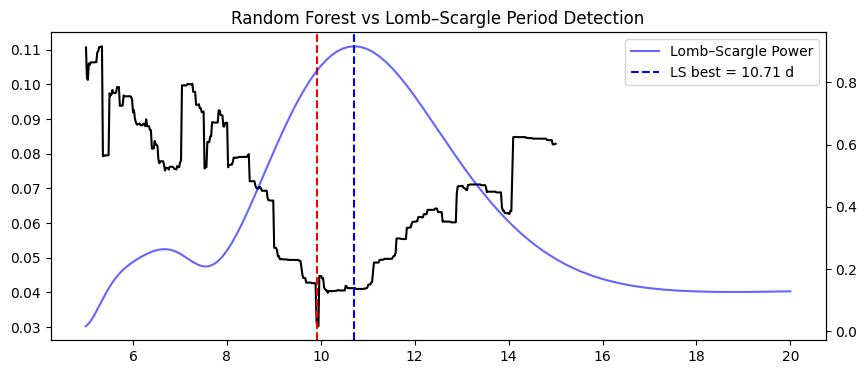

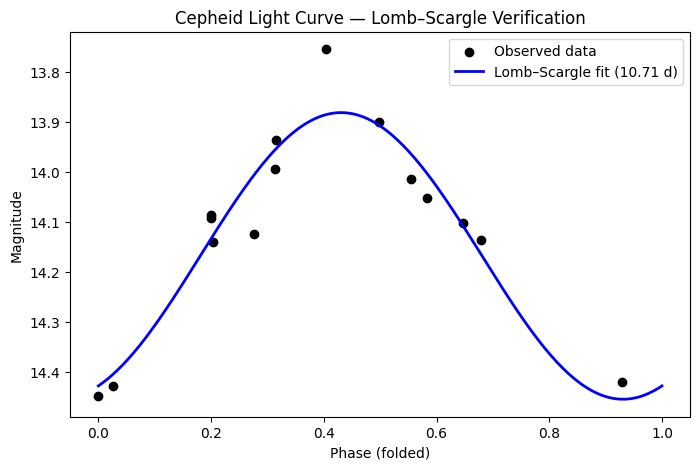

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from astropy.timeseries import LombScargle

# -----------------------------
# Input data
# -----------------------------
data = """DATE-OBS	space mag
2025-10-13T15:43:19	14.4487168764333
2025-10-15T19:02:31	14.0871593860654
2025-10-15T19:03:46	14.0926978705731
2025-10-16T14:53:04	14.1251353164749
2025-10-19T14:21:15	14.0148015986942
2025-10-20T13:59:25	14.1016092756703
2025-10-23T14:33:15	14.4204304303731
2025-10-24T15:32:45	14.4292004739213
2025-10-26T13:00:50	14.1395867367578
2025-10-27T17:32:41	13.9945536791067
2025-10-27T17:42:44	13.9356596711884
2025-10-28T16:39:00	13.7541091778157
2025-10-29T16:54:14	13.9004452749884
2025-10-30T14:37:14	14.0516422813395
2025-10-31T15:20:41	14.1357882019841
"""

# -----------------------------
# Load & preprocess
# -----------------------------
df = pd.read_csv(StringIO(data), sep="\t")
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])
df['days'] = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / (3600 * 24)

time = df['days'].values
mag = df['space mag'].values

# -----------------------------
# Random Forest Period Finder
# -----------------------------
def evaluate_period(period, time, mag):
    phase = (time % period) / period
    order = np.argsort(phase)
    phase, mag = phase[order], mag[order]
    rf = RandomForestRegressor(n_estimators=300, random_state=0)
    rf.fit(phase.reshape(-1, 1), mag)
    pred = rf.predict(phase.reshape(-1, 1))
    rms = np.sqrt(mean_squared_error(mag, pred))
    return rms

periods = np.linspace(5, 15, 500)
rms_values = [evaluate_period(p, time, mag) for p in periods]
rf_period = periods[np.argmin(rms_values)]
print(f"Random Forest estimated period: {rf_period:.2f} days")

# -----------------------------
# Lomb–Scargle Periodogram
# -----------------------------
freq, power = LombScargle(time, mag).autopower(
    minimum_frequency=1/20, maximum_frequency=1/5, samples_per_peak=50
)
ls_period = 1 / freq[np.argmax(power)]
print(f"Lomb–Scargle best period: {ls_period:.2f} days")

# -----------------------------
# Plot RMS (RF) and LS Periodogram
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(periods, rms_values, 'k-', label='Random Forest RMS')
plt.axvline(rf_period, color='r', linestyle='--', label=f'RF best = {rf_period:.2f} d')
plt.twinx()
plt.plot(1/freq, power, 'b-', alpha=0.6, label='Lomb–Scargle Power')
plt.axvline(ls_period, color='b', linestyle='--', label=f'LS best = {ls_period:.2f} d')
plt.xlabel("Period (days)")
plt.title("Random Forest vs Lomb–Scargle Period Detection")
plt.legend(loc='best')
plt.show()

# -----------------------------
# Lomb–Scargle model fit
# -----------------------------
model = LombScargle(time, mag)
phase = (time % ls_period) / ls_period
phase_fit = np.linspace(0, 1, 300)
mag_fit = model.model(time.min() + phase_fit * ls_period, freq[np.argmax(power)])

# -----------------------------
# Plot folded light curve
# -----------------------------
plt.figure(figsize=(8,5))
plt.scatter(phase, mag, color='black', label='Observed data')
plt.plot(phase_fit, mag_fit, color='blue', lw=2, label=f'Lomb–Scargle fit ({ls_period:.2f} d)')
plt.gca().invert_yaxis()
plt.xlabel("Phase (folded)")
plt.ylabel("Magnitude")
plt.title("Cepheid Light Curve — Lomb–Scargle Verification")
plt.legend()
plt.show()


In [22]:
import math

# Given values
a = -2.637
b = -4.088
P = 10.219
m = 14.255
A = 2.285
B = 1.79
E = A * B

# Uncertainties
sigma_a = 0.106
sigma_b = 0.032
sigma_P = 0.247 
sigma_m = 0.02
sigma_A = 0
sigma_B = 0.09

# Derived quantities
M = a * (math.log10(P) - 1) + b
d = 10 ** ((m - M - E + 5) / 5)

# Partial derivatives
ln10 = math.log(10)
dd_dm = (ln10 / 5) * d
dd_dM = - (ln10 / 5) * d
dd_dE = - (ln10 / 5) * d
dd_da = - (ln10 / 5) * d * (math.log10(P) - 1)
dd_db = - (ln10 / 5) * d
dd_dP = - (ln10 / 5) * d * (a / (P * ln10))
dd_dA = - (ln10 / 5) * d * B
dd_dB = - (ln10 / 5) * d * A

# Total uncertainty
sigma_d = math.sqrt(
    (dd_dm * sigma_m)**2 +
    (dd_da * sigma_a)**2 +
    (dd_db * sigma_b)**2 +
    (dd_dP * sigma_P)**2 +
    (dd_dA * sigma_A)**2 +
    (dd_dB * sigma_B)**2
)

# Results
print(f"M = {M:.3f}")
print(f"Distance = {d/1000:.3f} ± {sigma_d/1000:.3f} kpc")
print(f"Fractional Error = {sigma_d/d:.3%}")


M = -4.113
Distance = 7.170 ± 0.696 kpc
Fractional Error = 9.713%


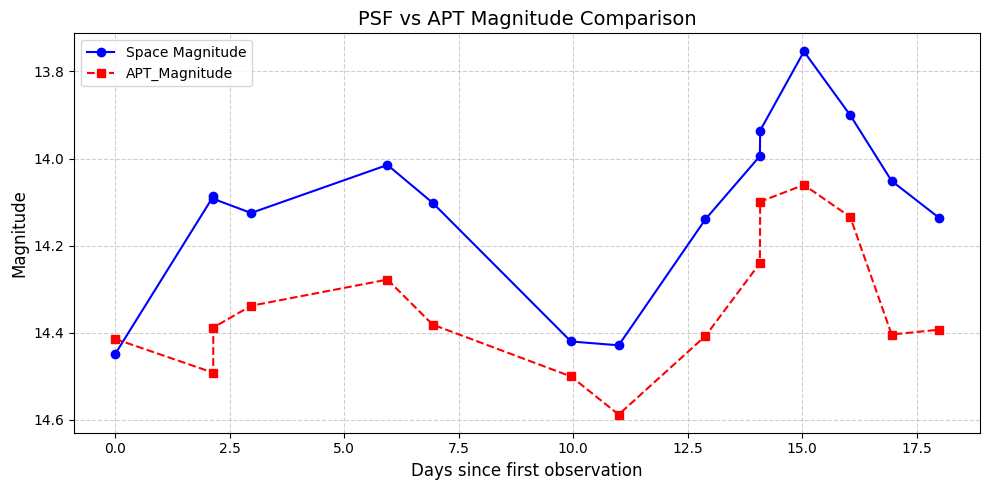

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# SPACE MAG DATA
# -------------------------
data_space = {
    'DATE-OBS': [
        '2025-10-13T15:43:19', '2025-10-15T19:02:31', '2025-10-15T19:03:46',
        '2025-10-16T14:53:04', '2025-10-19T14:21:15', '2025-10-20T13:59:25',
        '2025-10-23T14:33:15', '2025-10-24T15:32:45', '2025-10-26T13:00:50',
        '2025-10-27T17:32:41', '2025-10-27T17:42:44', '2025-10-28T16:39:00',
        '2025-10-29T16:54:14', '2025-10-30T14:37:14', '2025-10-31T15:20:41'
    ],
    'Space_mag': [
        14.4487168764333, 14.0871593860654, 14.0926978705731, 14.1251353164749,
        14.0148015986942, 14.1016092756703, 14.4204304303731, 14.4292004739213,
        14.1395867367578, 13.9945536791067, 13.9356596711884, 13.7541091778157,
        13.9004452749884, 14.0516422813395, 14.1357882019841
    ]
}
df_space = pd.DataFrame(data_space)
df_space['DATE-OBS'] = pd.to_datetime(df_space['DATE-OBS'])

# -------------------------
# PSF MAG DATA
# -------------------------
data_psf = {
    'DATE-OBS': [
        '2025-10-13T15:43:19', '2025-10-15T19:02:31', '2025-10-15T19:03:46',
        '2025-10-16T14:53:04', '2025-10-19T14:21:15', '2025-10-20T13:59:25',
        '2025-10-23T14:33:15', '2025-10-24T15:32:45', '2025-10-26T13:00:50',
        '2025-10-27T17:32:41', '2025-10-27T17:42:44', '2025-10-28T16:39:00',
        '2025-10-29T16:54:14', '2025-10-30T14:37:14', '2025-10-31T15:20:41'
    ],
    'PSF_mag': [
        14.4146526804189, 14.4922432865171, 14.3884733771649, 14.338384320076,
        14.2781520694278, 14.3815176245167, 14.500747492751, 14.5883576157975,
        14.4078207165552, 14.2405337434988, 14.099001989914, 14.0606906063435,
        14.1343046209967, 14.4043942436198, 14.3934706581914
    ]
}
df_psf = pd.DataFrame(data_psf)
df_psf['DATE-OBS'] = pd.to_datetime(df_psf['DATE-OBS'])

# -------------------------
# Convert to days since first observation
# -------------------------
t_space = (df_space['DATE-OBS'] - df_space['DATE-OBS'].min()).dt.total_seconds() / 86400
t_psf = (df_psf['DATE-OBS'] - df_psf['DATE-OBS'].min()).dt.total_seconds() / 86400

# -------------------------
# PLOT BOTH
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(t_space, df_space['Space_mag'], 'o-', label='Space Magnitude', color='blue')
plt.plot(t_psf, df_psf['PSF_mag'], 's--', label='APT_Magnitude', color='red')

plt.xlabel('Days since first observation', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.title('PSF vs APT Magnitude Comparison', fontsize=14)
plt.gca().invert_yaxis()  # smaller magnitude = brighter star
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


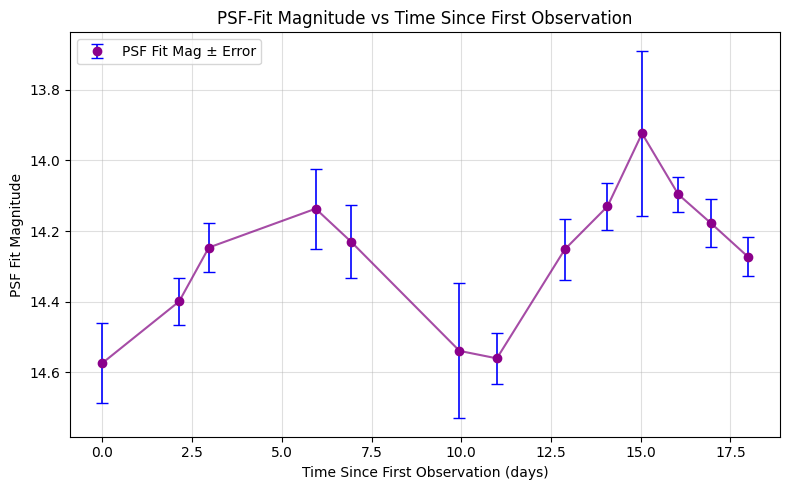

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Create the dataset
# -------------------------
data = {
    'PSF_Fit_Mag': [
        14.5740641960144, 14.3995603209968, 14.2467509963989, 14.1366495292664,
        14.2300916511536, 14.5396829376221, 14.5608428581238, 14.2517660202026,
        14.1300805729126, 13.9234185714722, 14.0961406539917, 14.1772480377197,
        14.2723175437927
    ],
    'PSF_Fit_Mag_Err': [
        0.114279077451875, 0.0654582261419562, 0.0683564345809944, 0.113156682243959,
        0.103854648423865, 0.191179385937817, 0.0719050575389739, 0.0864636487296842,
        0.0667216867549908, 0.234577555447312, 0.0492229828688842, 0.0689897636901574,
        0.055813687813578
    ],
    'DATE-OBS': [
        '2025-10-13T15:43:19', '2025-10-15T19:02:31', '2025-10-16T14:53:04',
        '2025-10-19T14:21:15', '2025-10-20T13:59:25', '2025-10-23T14:33:15',
        '2025-10-24T15:32:45', '2025-10-26T13:00:50', '2025-10-27T17:32:41',
        '2025-10-28T16:39:00', '2025-10-29T16:54:14', '2025-10-30T14:37:14',
        '2025-10-31T15:20:41'
    ]
}

# -------------------------
# Convert to DataFrame
# -------------------------
df = pd.DataFrame(data)
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])

# Compute time since first observation (in days)
df['Days_since_first'] = (df['DATE-OBS'] - df['DATE-OBS'].iloc[0]).dt.total_seconds() / (24 * 3600)

# -------------------------
# Plot PSF Magnitude vs Time with Error Bars and Line
# -------------------------
plt.figure(figsize=(8, 5))
plt.errorbar(df['Days_since_first'], df['PSF_Fit_Mag'],
             yerr=df['PSF_Fit_Mag_Err'],
             fmt='o', color='darkmagenta', ecolor='b',
             elinewidth=1.2, capsize=4, label='PSF Fit Mag ± Error')

# Add line connecting the points
plt.plot(df['Days_since_first'], df['PSF_Fit_Mag'],
         color='purple', linestyle='-', linewidth=1.5, alpha=0.7)

# Aesthetics
plt.gca().invert_yaxis()  # magnitude scale (lower mag = brighter)
plt.xlabel("Time Since First Observation (days)")
plt.ylabel("PSF Fit Magnitude")
plt.title("PSF-Fit Magnitude vs Time Since First Observation")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


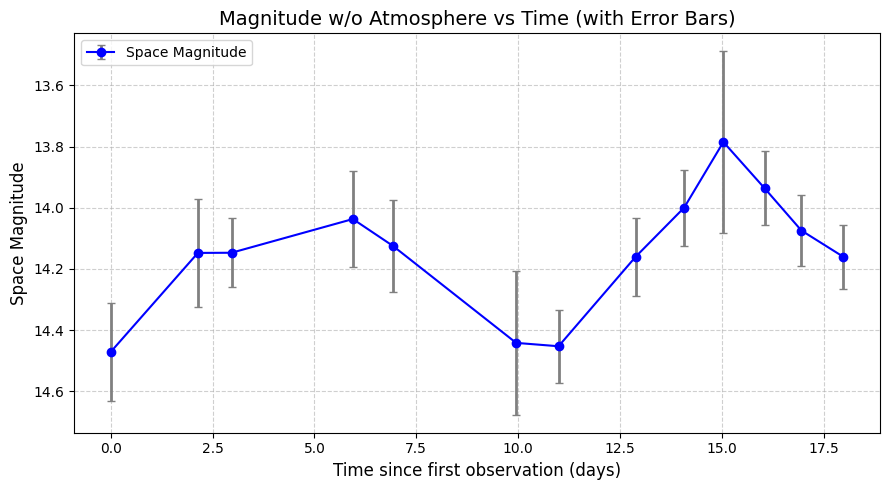

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated data
data = {
    'DATE-OBS': [
        '2025-10-13T15:43:19','2025-10-15T19:02:31','2025-10-16T14:53:04',
        '2025-10-19T14:21:15','2025-10-20T13:59:25','2025-10-23T14:33:15',
        '2025-10-24T15:32:45','2025-10-26T13:00:50','2025-10-27T17:32:41',
        '2025-10-28T16:39:00','2025-10-29T16:54:14','2025-10-30T14:37:14',
        '2025-10-31T15:20:41'
    ],
    'space mag': [
        14.4715072981753, 14.1477593736017, 14.1472472582793,
        14.0369557678892, 14.1249697075764, 14.4421127044184,
        14.4531354528672, 14.1599829701114, 13.9996081812298,
        13.784892703935, 13.936026252989, 14.0744796915904,
        14.1606117186766
    ],
    'Space err': [
        0.159859920935925, 0.177369758317575, 0.112580318189714,
        0.15746502063384, 0.150575512235956, 0.234543934028346,
        0.11977501543078, 0.1272561154369, 0.124709416391803,
        0.296144607686055, 0.120384938870093, 0.114664584192053,
        0.105460721198528
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])

# Convert to days since first observation
df['Time (days)'] = (df['DATE-OBS'] - df['DATE-OBS'].iloc[0]).dt.total_seconds() / (24*3600)

# Plot with error bars and line
plt.figure(figsize=(9,5))
plt.errorbar(df['Time (days)'], df['space mag'], yerr=df['Space err'],
             fmt='o-', color='b', ecolor='gray', elinewidth=2, capsize=3,
             markersize=6, label='Space Magnitude')

# Invert y-axis (lower mag = brighter)
plt.gca().invert_yaxis()

# Labels & title
plt.xlabel("Time since first observation (days)", fontsize=12)
plt.ylabel("Space Magnitude", fontsize=12)
plt.title("Magnitude w/o Atmosphere vs Time (with Error Bars)", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [103]:
import pandas as pd

# Your data
data = {
    "space mag": [
        14.4715072981753, 14.1477593736017, 14.1472472582793, 14.0369557678892,
        14.1249697075764, 14.4421127044184, 14.4531354528672, 14.1599829701114,
        13.9996081812298, 13.784892703935, 13.936026252989, 14.0744796915904,
        14.1606117186766
    ],
    "Space err": [
        0.159859920935925, 0.177369758317575, 0.112580318189714, 0.15746502063384,
        0.150575512235956, 0.234543934028346, 0.11977501543078, 0.1272561154369,
        0.124709416391803, 0.296144607686055, 0.120384938870093, 0.114664584192053,
        0.105460721198528
    ]
}

df = pd.DataFrame(data)

# Weighted mean
weights = 1 / (df['Space err']**2)
weighted_mean = (df['space mag'] * weights).sum() / weights.sum()

# Error in weighted mean
error_mean = (1 / weights.sum())**0.5

print(f"Weighted mean of space mag: {weighted_mean:.5f}")
print(f"Error in mean: {error_mean:.5f}")


Weighted mean of space mag: 14.15043
Error in mean: 0.03794


In [105]:
import pandas as pd
import numpy as np

# Your data
data = {
    "space mag": [
        14.4715072981753, 14.1477593736017, 14.1472472582793, 14.0369557678892,
        14.1249697075764, 14.4421127044184, 14.4531354528672, 14.1599829701114,
        13.9996081812298, 13.784892703935, 13.936026252989, 14.0744796915904,
        14.1606117186766
    ],
    "Space err": [
        0.159859920935925, 0.177369758317575, 0.112580318189714, 0.15746502063384,
        0.150575512235956, 0.234543934028346, 0.11977501543078, 0.1272561154369,
        0.124709416391803, 0.296144607686055, 0.120384938870093, 0.114664584192053,
        0.105460721198528
    ]
}

df = pd.DataFrame(data)

# 1. Convert magnitudes to flux
df['flux'] = 10 ** (-0.4 * df['space mag'])

# 2. Convert magnitude errors to flux errors
df['flux_err'] = 0.9210 * df['flux'] * df['Space err']

# 3. Weighted mean flux
weights = 1 / (df['flux_err'] ** 2)
mean_flux = (df['flux'] * weights).sum() / weights.sum()

# 4. Error in mean flux
mean_flux_err = np.sqrt(1 / weights.sum())

# 5. Convert mean flux back to magnitude and compute error
mean_mag = -2.5 * np.log10(mean_flux)
mean_mag_err = 1.0857 * (mean_flux_err / mean_flux)

print(f"Mean magnitude: {mean_mag:.5f}")
print(f"Error in mean magnitude: {mean_mag_err:.5f}")


Mean magnitude: 14.19137
Error in mean magnitude: 0.03843


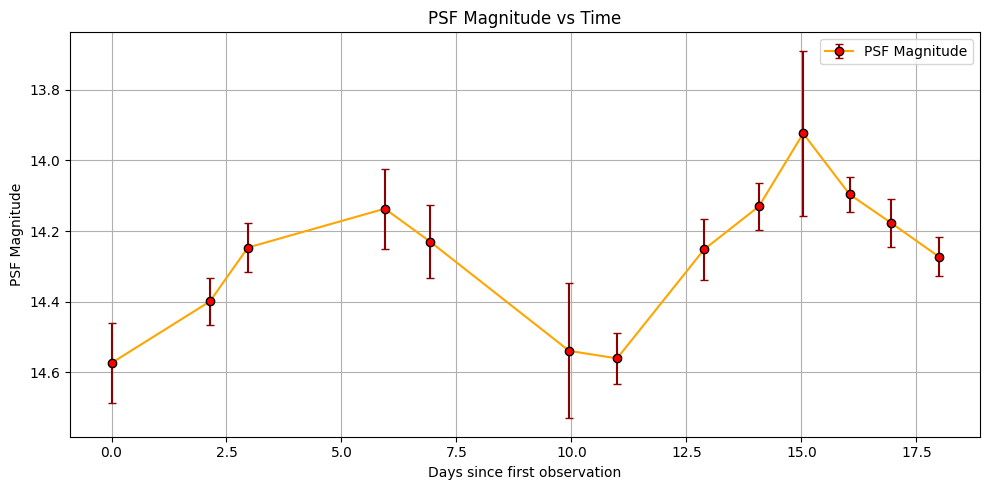

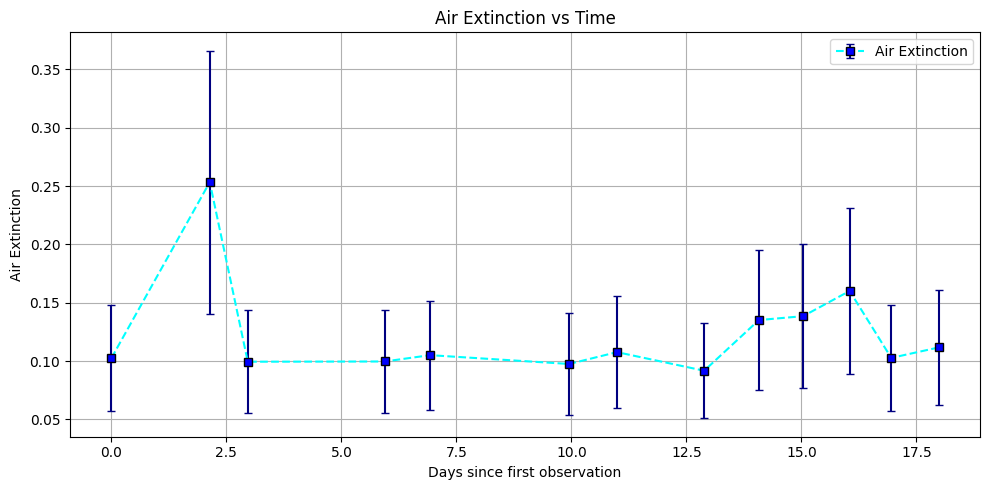

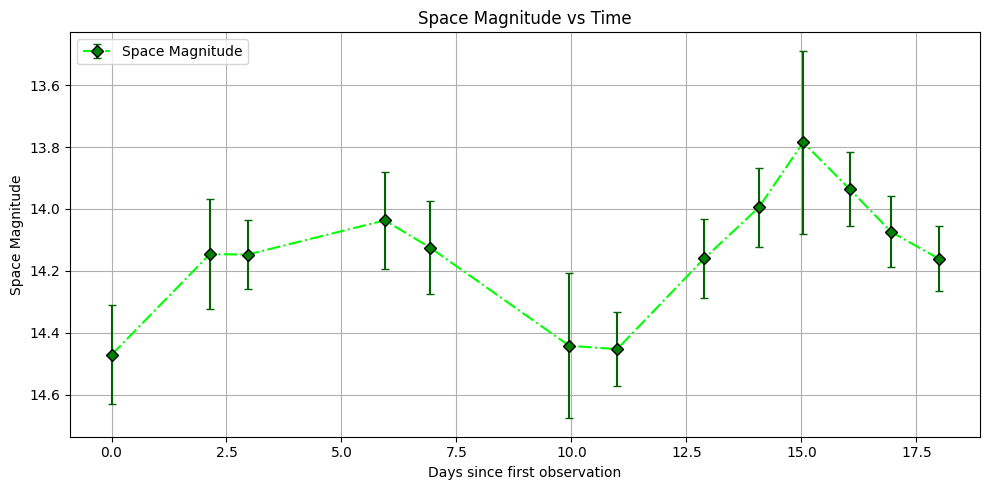

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('/home/adarsh/Documents/Astro/Berkeley51/CepheidFinal.csv')

# Convert DATE-OBS to datetime
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])

# Compute days since first observation
df['days_since'] = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / 86400

# --- PSF Magnitude Plot ---
plt.figure(figsize=(10,5))
plt.errorbar(df['days_since'], df['PSF_Fit_Mag'], 
             yerr=df['PSF_Fit_Mag_Err'], fmt='o', capsize=3, 
             ecolor='darkred', markerfacecolor='red', markeredgecolor='black', markersize=6, 
             linestyle='-', color='orange', label='PSF Magnitude')
plt.xlabel("Days since first observation")
plt.ylabel("PSF Magnitude")
plt.title("PSF Magnitude vs Time")
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

# --- Air Extinction Plot ---
plt.figure(figsize=(10,5))
plt.errorbar(df['days_since'], df['Air ext'], 
             yerr=df['air err'], fmt='s', capsize=3, 
             ecolor='navy', markerfacecolor='blue', markeredgecolor='black', markersize=6,
             linestyle='--', color='cyan', label='Air Extinction')
plt.xlabel("Days since first observation")
plt.ylabel("Air Extinction")
plt.title("Air Extinction vs Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Space Magnitude Plot ---
plt.figure(figsize=(10,5))
plt.errorbar(df['days_since'], df['space mag'], 
             yerr=df['Space err'], fmt='D', capsize=3, 
             ecolor='darkgreen', markerfacecolor='green', markeredgecolor='black', markersize=6,
             linestyle='-.', color='lime', label='Space Magnitude')
plt.xlabel("Days since first observation")
plt.ylabel("Space Magnitude")
plt.title("Space Magnitude vs Time")
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()


Best period from Lomb-Scargle: 10.484 days


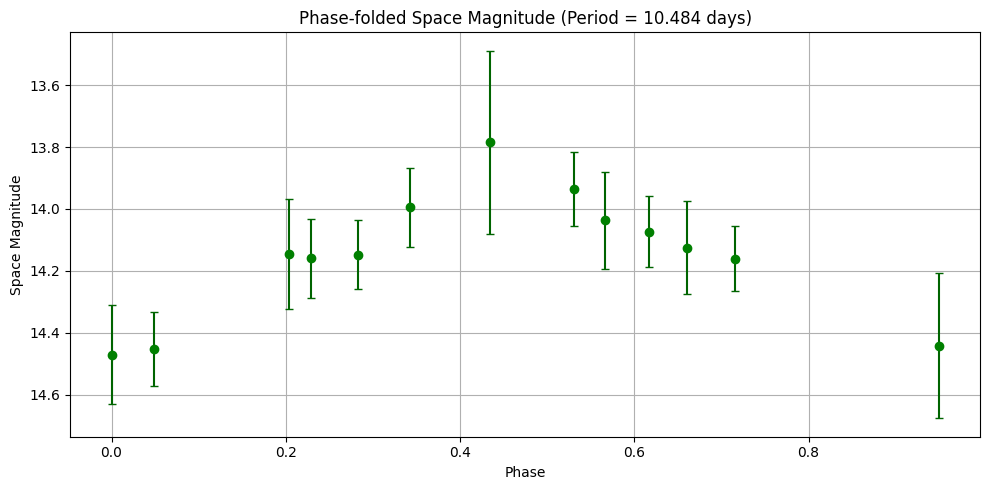

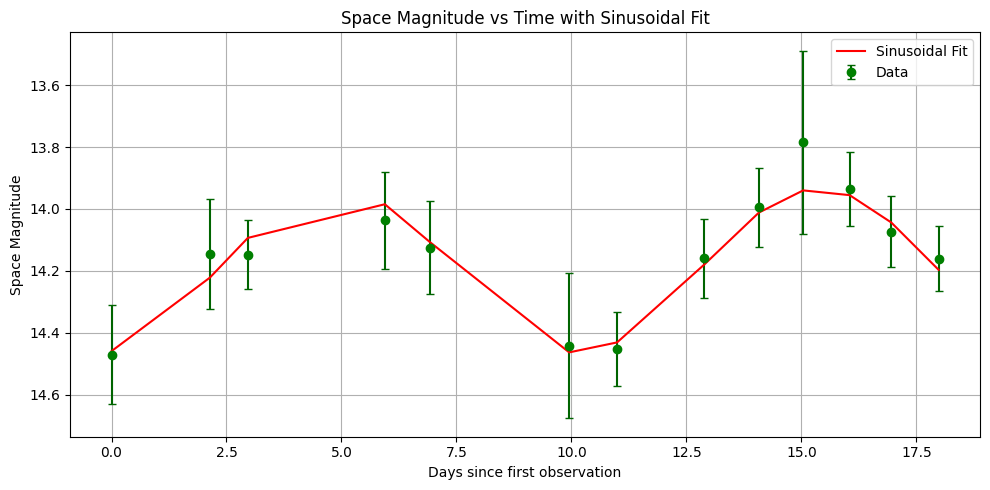

Fitted sinusoid parameters: Amplitude=0.265, Phase=1.777, Offset=14.200


In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

# Convert DATE-OBS to datetime
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])

# Time in days since first observation
t = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / 86400
y = df['space mag'].values
yerr = df['Space err'].values

# --- Lomb-Scargle Periodogram ---
# Set frequency range: freq = 1/period
min_period = 0.1  # days
max_period = (t.max() - t.min())  # maximum period = full time span
frequency = np.linspace(1/max_period, 1/min_period, 10000)
ls = LombScargle(t, y, dy=yerr)
power = ls.power(frequency)

# Find the best frequency
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(f"Best period from Lomb-Scargle: {best_period:.3f} days")

# Phase fold the data for visualization
phase = (t % best_period) / best_period
plt.figure(figsize=(10,5))
plt.errorbar(phase, y, yerr=yerr, fmt='o', color='green', ecolor='darkgreen', capsize=3)
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Space Magnitude")
plt.title(f"Phase-folded Space Magnitude (Period = {best_period:.3f} days)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: Fit sinusoid ---
from scipy.optimize import curve_fit

def sinusoid(t, A, phi, offset):
    return offset + A * np.sin(2 * np.pi * t / best_period + phi)

# Fit sinusoid
popt, pcov = curve_fit(sinusoid, t, y, sigma=yerr, absolute_sigma=True, p0=[0.1, 0, np.mean(y)])
y_fit = sinusoid(t, *popt)

# Plot original data with fitted sinusoid
plt.figure(figsize=(10,5))
plt.errorbar(t, y, yerr=yerr, fmt='o', color='green', ecolor='darkgreen', capsize=3, label='Data')
plt.plot(t, y_fit, 'r-', label='Sinusoidal Fit')
plt.gca().invert_yaxis()
plt.xlabel("Days since first observation")
plt.ylabel("Space Magnitude")
plt.title("Space Magnitude vs Time with Sinusoidal Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Fitted sinusoid parameters: Amplitude={popt[0]:.3f}, Phase={popt[1]:.3f}, Offset={popt[2]:.3f}")


Best Lomb–Scargle frequency: 0.09785 1/day
Best Lomb–Scargle period: 10.219 days


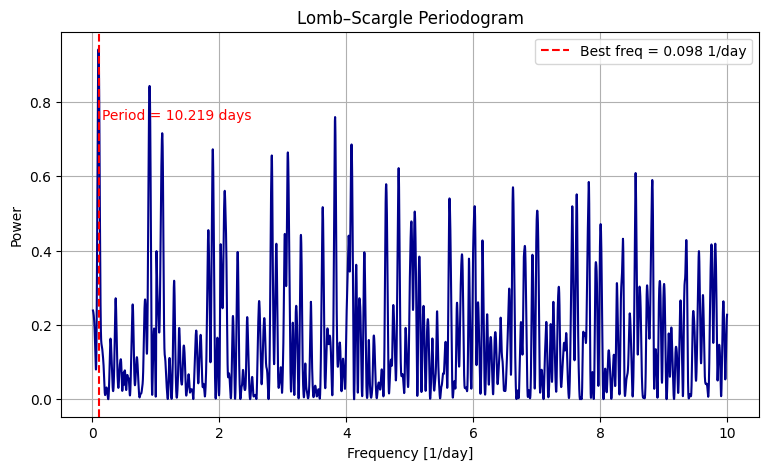

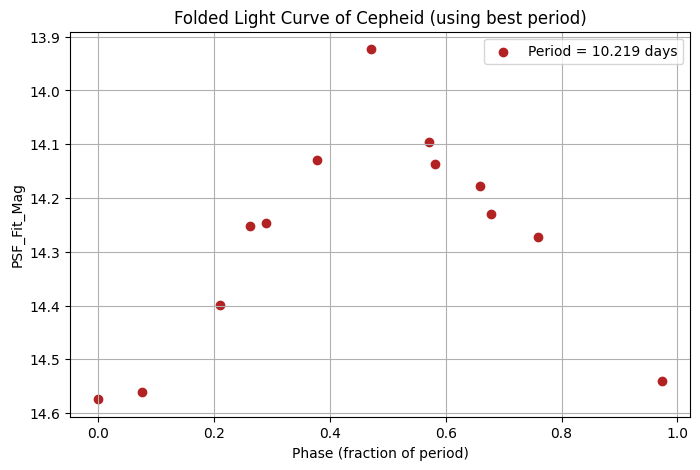

In [3]:
import pandas as pd
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

# -----------------------------
# Data
# -----------------------------
data = {
    'DATE-OBS': [
        '2025-10-13T15:43:19', '2025-10-15T19:02:31', '2025-10-16T14:53:04',
        '2025-10-19T14:21:15', '2025-10-20T13:59:25', '2025-10-23T14:33:15',
        '2025-10-24T15:32:45', '2025-10-26T13:00:50', '2025-10-27T17:32:41',
        '2025-10-28T16:39:00', '2025-10-29T16:54:14', '2025-10-30T14:37:14',
        '2025-10-31T15:20:41'
    ],
    'PSF_Fit_Mag': [
        14.5740641960144, 14.3995603209968, 14.2467509963989,
        14.1366495292664, 14.2300916511536, 14.5396829376221,
        14.5608428581238, 14.2517660202026, 14.1300805729126,
        13.9234185714722, 14.0961406539917, 14.1772480377197,
        14.2723175437927
    ]
}

df = pd.DataFrame(data)

# -----------------------------
# Convert DATE-OBS to days since first observation
# -----------------------------
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])
df['days'] = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / (24*3600)

time = df['days'].values
mag = df['PSF_Fit_Mag'].values

# -----------------------------
# Lomb–Scargle Periodogram
# -----------------------------
frequency, power = LombScargle(time, -mag).autopower(
    minimum_frequency=0.01,  # search from 0.1 to 10 cycles/day
    maximum_frequency=10,
    samples_per_peak=50
)

best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

print(f"Best Lomb–Scargle frequency: {best_frequency:.5f} 1/day")
print(f"Best Lomb–Scargle period: {best_period:.3f} days")

# -----------------------------
# Plot the periodogram with annotation
# -----------------------------
plt.figure(figsize=(9,5))
plt.plot(frequency, power, color='darkblue', lw=1.5)
plt.axvline(best_frequency, color='red', linestyle='--', label=f'Best freq = {best_frequency:.3f} 1/day')
plt.text(best_frequency + 0.05, power.max()*0.8,
         f'Period = {best_period:.3f} days',
         color='red', fontsize=10, rotation=0)

plt.xlabel("Frequency [1/day]")
plt.ylabel("Power")
plt.title("Lomb–Scargle Periodogram")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Folded light curve (Phase plot)
# -----------------------------
phase = (time / best_period) % 1
plt.figure(figsize=(8,5))
plt.scatter(phase, mag, color='firebrick', label=f'Period = {best_period:.3f} days')
plt.gca().invert_yaxis()
plt.xlabel("Phase (fraction of period)")
plt.ylabel("PSF_Fit_Mag")
plt.title("Folded Light Curve of Cepheid (using best period)")
plt.legend()
plt.grid(True)
plt.show()


In [157]:
import pandas as pd
import numpy as np
from astropy.timeseries import LombScargle
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])

t = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / 86400
y = df['space mag'].values
yerr = df['Space err'].values

# Lomb-Scargle frequency grid
min_period = 0.1
max_period = t.max() - t.min()
frequency = np.linspace(1/max_period, 1/min_period, 10000)

# Original best period
ls = LombScargle(t, y, dy=yerr)
power = ls.power(frequency)
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(f"Best period: {best_period:.3f} days")

# --- Bootstrap to estimate period error ---
n_bootstrap = 1000
periods = []

for i in range(n_bootstrap):
    y_sim = y + np.random.normal(0, yerr)  # add Gaussian noise
    ls_sim = LombScargle(t, y_sim, dy=yerr)
    power_sim = ls_sim.power(frequency)
    best_f_sim = frequency[np.argmax(power_sim)]
    periods.append(1 / best_f_sim)

period_error = np.std(periods)
print(f"Estimated period error: {period_error:.3f} days")


Best period: 10.484 days
Estimated period error: 4.780 days


Best period from Lomb-Scargle: 10.484 days
Fitted amplitude = 0.265, phase = 1.777, offset = 14.200


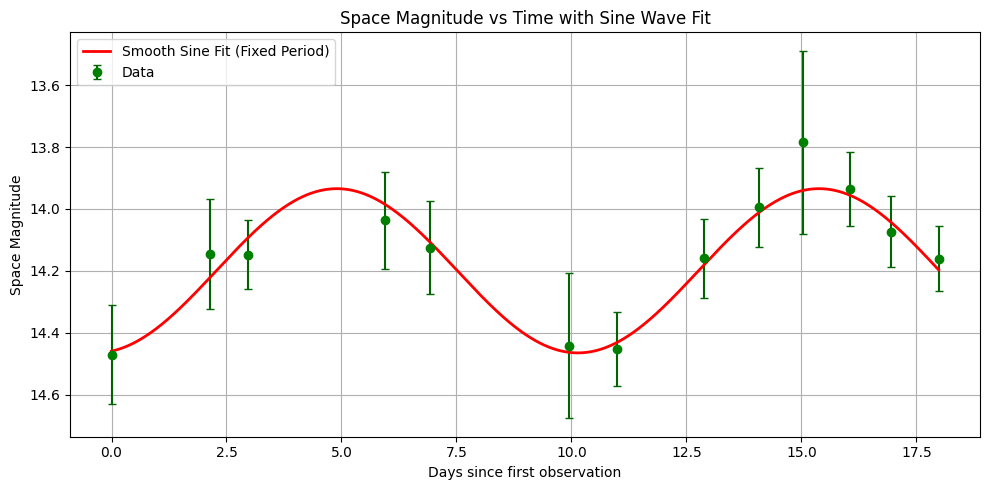

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])

# Time in days
t = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / 86400
y = df['space mag'].values
yerr = df['Space err'].values

# --- Lomb-Scargle periodogram ---
min_period = 0.1
max_period = t.max() - t.min()
frequency = np.linspace(1/max_period, 1/min_period, 10000)
ls = LombScargle(t, y, dy=yerr)
power = ls.power(frequency)

best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(f"Best period from Lomb-Scargle: {best_period:.3f} days")

# --- Define sine function with fixed period ---
def sine_fixed_period(t, A, phi, offset):
    return offset + A * np.sin(2 * np.pi * t / best_period + phi)

# Initial guess: amplitude ~ half peak-to-peak, phase=0, offset=mean
A_guess = 0.5 * (y.max() - y.min())
offset_guess = np.mean(y)
phi_guess = 0
p0 = [A_guess, phi_guess, offset_guess]

# Fit sine wave
popt, pcov = curve_fit(sine_fixed_period, t, y, sigma=yerr, absolute_sigma=True, p0=p0)
A_fit, phi_fit, offset_fit = popt
print(f"Fitted amplitude = {A_fit:.3f}, phase = {phi_fit:.3f}, offset = {offset_fit:.3f}")

# --- Smooth sine wave ---
t_smooth = np.linspace(t.min(), t.max(), 1000)
y_smooth = sine_fixed_period(t_smooth, *popt)

# --- Plot ---
plt.figure(figsize=(10,5))
plt.errorbar(t, y, yerr=yerr, fmt='o', color='green', ecolor='darkgreen', capsize=3, label='Data')
plt.plot(t_smooth, y_smooth, 'r-', linewidth=2, label='Smooth Sine Fit (Fixed Period)')
plt.gca().invert_yaxis()
plt.xlabel("Days since first observation")
plt.ylabel("Space Magnitude")
plt.title("Space Magnitude vs Time with Sine Wave Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Top 5 candidate periods (ignoring ~1-day alias):
1: 9.596 days, power = 0.711
2: 1.121 days, power = 0.652
3: 0.530 days, power = 0.578
4: 0.899 days, power = 0.574
5: 0.879 days, power = 0.463


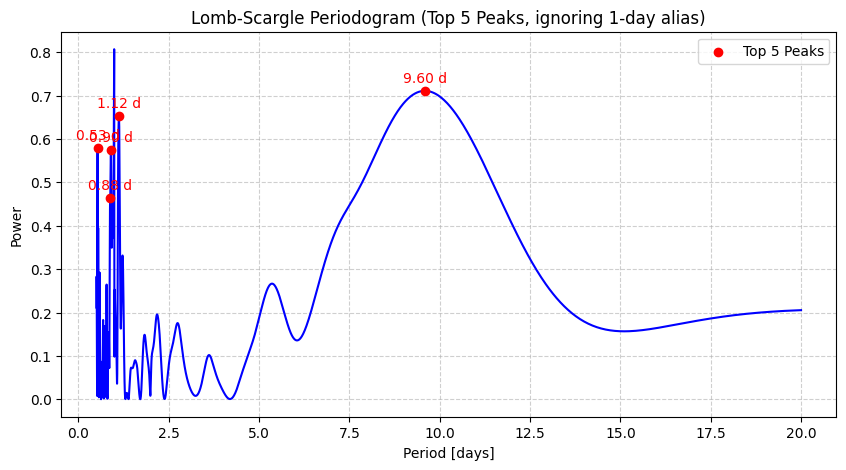

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks

# -------------------------
# Data
# -------------------------

df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])

# -------------------------
# Time in days
# -------------------------
t = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / 86400
y = df['Space_apt'].values

# -------------------------
# Lomb-Scargle periodogram
# -------------------------
min_period = 0.5  # avoid very short alias
max_period = 20   # plausible Cepheid periods
frequency = np.linspace(1/max_period, 1/min_period, 10000)

ls = LombScargle(t, y)
power = ls.power(frequency)

# -------------------------
# Find peaks
# -------------------------
peaks, _ = find_peaks(power)
peak_powers = power[peaks]
peak_frequencies = frequency[peaks]

# Filter out peaks corresponding to periods ~0.95-1.05 days (alias)
valid = (1/peak_frequencies < 0.95) | (1/peak_frequencies > 1.05)
peak_frequencies = peak_frequencies[valid]
peak_powers = peak_powers[valid]

# Sort top 5 peaks by power
sorted_idx = np.argsort(peak_powers)[::-1]
top5_peaks = sorted_idx[:5]

best_periods = 1 / peak_frequencies[top5_peaks]
best_powers = peak_powers[top5_peaks]

print("Top 5 candidate periods (ignoring ~1-day alias):")
for i, (p, pw) in enumerate(zip(best_periods, best_powers), 1):
    print(f"{i}: {p:.3f} days, power = {pw:.3f}")

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(10,5))
plt.plot(1/frequency, power, color='blue')
plt.scatter(best_periods, best_powers, color='red', zorder=5, label='Top 5 Peaks')
for i, p in enumerate(best_periods):
    plt.text(p, best_powers[i] + 0.02, f"{p:.2f} d", ha='center', color='red')
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram (Top 5 Peaks, ignoring 1-day alias)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [175]:
# Assume frequency and power already computed
best_freq = peak_frequencies[top5_peaks[0]]  # highest power among top 5
best_power = peak_powers[top5_peaks[0]]

# Half-max
half_max = best_power / 2

# Indices near the peak where power drops below half_max
indices = np.where(power >= half_max)[0]

# Take min and max frequencies in this region
f_min = frequency[indices[0]]
f_max = frequency[indices[-1]]

# Convert to period
period_best = 1 / best_freq
period_min = 1 / f_max
period_max = 1 / f_min

period_error = 0.5 * (period_max - period_min)
print(f"Period = {period_best:.3f} ± {period_error:.3f} days")


Period = 9.596 ± 5.881 days


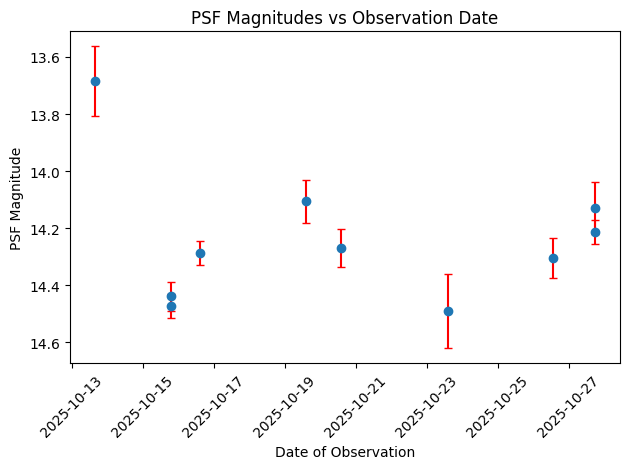

In [182]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the data
data = {
    "DATE-OBS": [
        "2025-10-13T15:43:19", "2025-10-15T19:02:31", "2025-10-15T19:03:46",
        "2025-10-16T14:53:04", "2025-10-16T17:48:02", "2025-10-19T14:21:15",
        "2025-10-20T13:59:25", "2025-10-23T14:33:15", "2025-10-24T15:32:45",
        "2025-10-26T13:00:50", "2025-10-27T17:32:41", "2025-10-27T17:42:44"
    ],
    "Processed_PSF_Mag": [
        13.685, 14.438, 14.474, 14.287, None, 14.106,
        14.27, 14.49, None, 14.305, 14.213, 14.129
    ],
    "Processed_PSF_Mag_Err": [
        0.122, 0.051, 0.042, 0.041, None, 0.074,
        0.067, 0.13, None, 0.069, 0.043, 0.09
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)
df["DATE-OBS"] = pd.to_datetime(df["DATE-OBS"])

# Drop rows with missing magnitude
df_plot = df.dropna(subset=["Processed_PSF_Mag"])

# Plot
plt.errorbar(df_plot["DATE-OBS"], df_plot["Processed_PSF_Mag"],
             yerr=df_plot["Processed_PSF_Mag_Err"], fmt='o', ecolor='red', capsize=3)
plt.gca().invert_yaxis()  # Magnitudes are brighter when smaller
plt.xlabel("Date of Observation")
plt.ylabel("PSF Magnitude")
plt.title("PSF Magnitudes vs Observation Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Best Lomb–Scargle period: 10.104 days
Best period = 6.203 ± 4.977 days


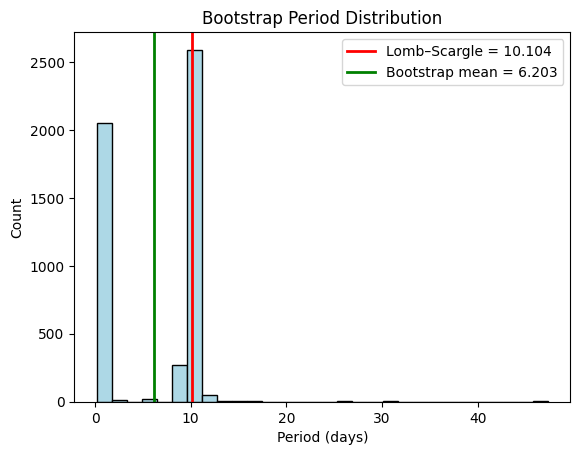

In [19]:
import pandas as pd
from astropy.timeseries import LombScargle
import numpy as np

# Load data
# Convert date to numerical days
df['DATE-OBS'] = pd.to_datetime(df['DATE-OBS'])
df['time_days'] = (df['DATE-OBS'] - df['DATE-OBS'].min()).dt.total_seconds() / (24 * 3600)

# Extract columns
t = df['time_days'].values
y = df['PSF_Fit_Mag'].values
yerr = df['PSF_Fit_Mag_Err'].values
frequency, power = LombScargle(t, y, yerr).autopower(minimum_frequency=0.01, maximum_frequency=100)
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

print(f"Best Lomb–Scargle period: {best_period:.3f} days")
n_boot = 5000
periods = []

for i in range(n_boot):
    # Resample data with replacement
    idx = np.random.randint(0, len(t), len(t))
    t_boot, y_boot, yerr_boot = t[idx], y[idx], yerr[idx]

    freq, power = LombScargle(t_boot, y_boot, yerr_boot).autopower(
        minimum_frequency=0.01, maximum_frequency=5
    )
    best_f_boot = freq[np.argmax(power)]
    periods.append(1 / best_f_boot)

periods = np.array(periods)
period_mean = np.mean(periods)
period_std = np.std(periods)

print(f"Best period = {period_mean:.3f} ± {period_std:.3f} days")
plt.hist(periods, bins=30, color='lightblue', edgecolor='k')
plt.axvline(best_period, color='r', lw=2, label=f'Lomb–Scargle = {best_period:.3f}')
plt.axvline(period_mean, color='g', lw=2, label=f'Bootstrap mean = {period_mean:.3f}')
plt.legend()
plt.xlabel('Period (days)')
plt.ylabel('Count')
plt.title('Bootstrap Period Distribution')
plt.show()



Initial best period: 10.315 days
Bootstrap best period: 10.309 ± 0.247 days


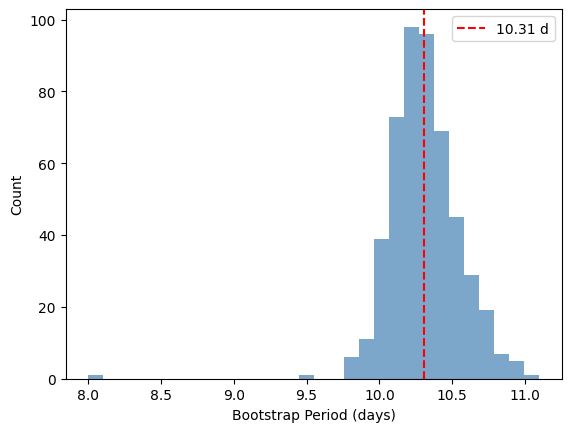

In [21]:
import numpy as np
from astropy.timeseries import LombScargle

# Assuming you already have these arrays:
# time, mag, mag_err

# --- Step 1: Narrow the period search range around 10 days ---
min_period, max_period = 8, 12  # focus around the 10-day signal
frequency = np.linspace(1/max_period, 1/min_period, 10000)

# --- Step 2: Compute initial Lomb–Scargle period ---
ls = LombScargle(time, mag, mag_err)
power = ls.power(frequency)
best_freq = frequency[np.argmax(power)]
best_period = 1 / best_freq
print(f"Initial best period: {best_period:.3f} days")

# --- Step 3: Bootstrap to estimate period uncertainty ---
n_bootstrap = 500
bootstrap_periods = []

for _ in range(n_bootstrap):
    # resample with replacement
    indices = np.random.choice(len(time), len(time), replace=True)
    time_b = time[indices]
    mag_b = mag[indices]
    err_b = mag_err[indices]

    ls_b = LombScargle(time_b, mag_b, err_b)
    power_b = ls_b.power(frequency)
    best_freq_b = frequency[np.argmax(power_b)]
    bootstrap_periods.append(1 / best_freq_b)

# --- Step 4: Compute statistics ---
period_mean = np.mean(bootstrap_periods)
period_std = np.std(bootstrap_periods)

print(f"Bootstrap best period: {period_mean:.3f} ± {period_std:.3f} days")

# --- Optional: visualize ---
import matplotlib.pyplot as plt
plt.hist(bootstrap_periods, bins=30, color='steelblue', alpha=0.7)
plt.axvline(period_mean, color='r', linestyle='--', label=f'{period_mean:.2f} d')
plt.xlabel("Bootstrap Period (days)")
plt.ylabel("Count")
plt.legend()
plt.show()
